In [ ]:
from ultralytics.data.annotator import auto_annotate

# Modify these paths according to your setup
data_path = "dataset/frames"  # Path to the folder containing your images
det_model = "yolov9e.pt"  # Path to a pre-trained YOLO detection model (e.g., yolov8n.pt)
output_dir = "dataset/annotations"  # Path to the folder where the annotations will be saved

# Run automatic annotation
auto_annotate(data=data_path, det_model=det_model, output_dir=output_dir)

print("Automatic annotation completed. Please review and adjust annotations as needed.")

### Auto annotations

In [2]:
import os
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov9e.pt')

# Get all image filenames in the 'dataset/frames/' directory
image_dir = 'datasets/auto_annotated_dataset/frames'
image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Iterate through each image filename
for image_filename in image_filenames:
    # Extract the image name without extension

    image_path = os.path.join(image_dir, image_filename)

    # Perform object detection with YOLO
    predictions = model(image_path, save_txt=False)  

### Save with class names

In [3]:
with open("predicted_labels.txt", '+w') as file:
      for idx, prediction in enumerate(predictions[0].boxes.xywhn): # change final attribute to desired box format
          cls = int(predictions[0].boxes.cls[idx].item())
          path = predictions[0].path
          class_name = model.names[cls]
          # Write line to file in YOLO label format : cls x y w h
          file.write(f"{path} {class_name} {cls} {prediction[0].item()} {prediction[1].item()} {prediction[2].item()} {prediction[3].item()}\n")

### Visualise and verify annotations

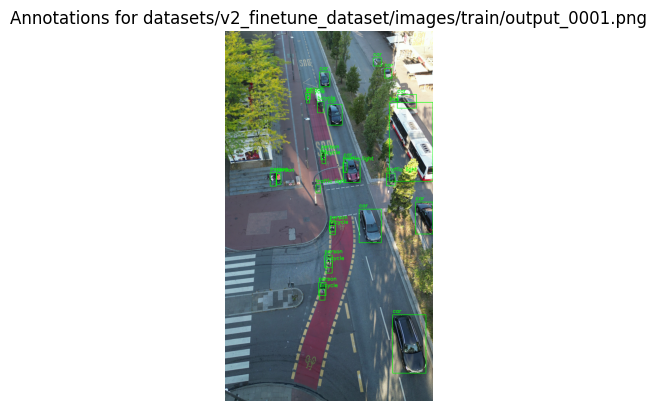

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
from collections import defaultdict

def load_class_names(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
        class_names = data['names']
    return class_names

def plot_annotations(annotation_file, class_names_file):
    # Create a dictionary to store annotations for each image
    annotations = defaultdict(list)
    
    # Extract the base name of the annotation file
    base_name = os.path.splitext(os.path.basename(annotation_file))[0]
    
    # Construct the corresponding image path
    image_path = os.path.join('datasets','v2_finetune_dataset', 'images','train', f'{base_name}.png')
    
    # Read the annotation file
    with open(annotation_file, 'r') as file:
        lines = file.readlines()

    # Parse the annotations and store them in the dictionary
    for line in lines:
        parts = line.strip().split()
        class_index = parts[0]
        x_center, y_center, width, height = map(float, parts[1:])
        annotations[image_path].append((class_index, x_center, y_center, width, height))
    
    # Load class names
    class_names = load_class_names(class_names_file)
    
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return
    
    h, w = image.shape[:2]

    # Draw all the annotations on the image
    for class_index, x_center, y_center, width, height in annotations[image_path]:
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        color = (0, 255, 0)  # Green color for bounding box
        class_name = class_names[int(class_index)]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Display the image with all annotations
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Annotations for {image_path}')
    plt.show()

# Call the function with your annotation file
plot_annotations('datasets/v2_finetune_dataset/labels/train/output_0001.txt', 'datasets/auto_annotated_dataset/data.yml')

In [3]:
import os
import shutil
from glob import glob

# Paths
images_dir = '/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/dataset/frames/'
annotations_dir = '/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/dataset/annotations/'
output_dir = 'archive'

# Create output directories
os.makedirs(output_dir, exist_ok=True)
subset_dir = os.path.join(output_dir, 'obj_train_data')
os.makedirs(subset_dir, exist_ok=True)

# File paths
train_txt_path = os.path.join(output_dir, 'train.txt')
obj_data_path = os.path.join(output_dir, 'obj.data')
obj_names_path = os.path.join(output_dir, 'obj.names')

# Class names
class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane",
    "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird"
]

# Create obj.names
with open(obj_names_path, 'w') as f:
    for name in class_names:
        f.write(f"{name}\n")

# Create train.txt
with open(train_txt_path, 'w') as train_file:
    image_files = glob(os.path.join(images_dir, '*.png'))
    for image_path in image_files:
        image_name = os.path.basename(image_path)
        annotation_path = os.path.join(annotations_dir, os.path.splitext(image_name)[0] + '.txt')

        if os.path.exists(annotation_path):
            valid_annotation = False
            filtered_lines = []

            with open(annotation_path, 'r') as annotation_file:
                lines = annotation_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    if class_id < len(class_names):
                        valid_annotation = True
                        filtered_lines.append(line)

            if valid_annotation:
                # Copy image to subset directory
                shutil.copy(image_path, os.path.join(subset_dir, image_name))

                # Write filtered annotations to the new file
                annotation_output_path = os.path.join(subset_dir, os.path.splitext(image_name)[0] + '.txt')
                with open(annotation_output_path, 'w') as output_file:
                    output_file.writelines(filtered_lines)

                # Add image path to train.txt
                train_file.write(f"obj_train_data/{image_name}\n")

# Create obj.data
with open(obj_data_path, 'w') as f:
    f.write("classes = {}\n".format(len(class_names)))
    f.write("names = obj.names\n")
    f.write("train = train.txt\n")
    f.write("valid = valid.txt\n")  # Assuming you might have a valid.txt in the future
    f.write("backup = backup/\n")

print(f"YOLO format conversion completed. Output archived in {output_dir}")

# Create the ZIP file
shutil.make_archive(output_dir, 'zip', output_dir)
print(f"Archive created: {output_dir}")

YOLO format conversion completed. Output archived in archive
Archive created: archive
